In [11]:
import yfinance as yf

In [106]:
nse = yf.Ticker("^NSEI")
nse = nse.history(period = "max")

<Axes: xlabel='Date'>

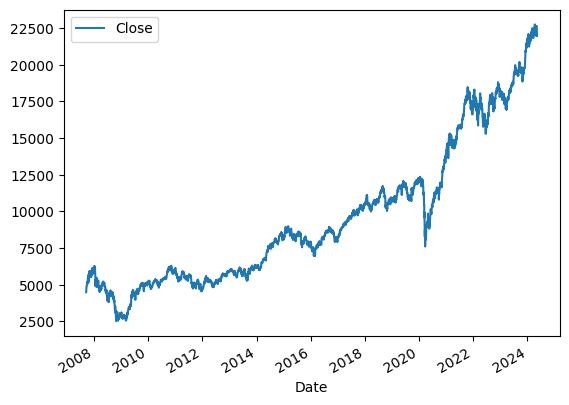

In [107]:
nse.plot.line(y="Close", use_index = True)

In [108]:
del nse['Dividends']
del nse['Stock Splits']

In [109]:
nse['Tomorrow'] = nse['Close'].shift(-1)

In [110]:
nse['Target'] = (nse['Tomorrow'] > nse['Close']).astype(int)


In [111]:
nse = nse.loc['2007-01-01':].copy()
nse

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2007-09-17 00:00:00+05:30,4518.450195,4549.049805,4482.850098,4494.649902,0,4546.200195,1
2007-09-18 00:00:00+05:30,4494.100098,4551.799805,4481.549805,4546.200195,0,4732.350098,1
2007-09-19 00:00:00+05:30,4550.250000,4739.000000,4550.250000,4732.350098,0,4747.549805,1
2007-09-20 00:00:00+05:30,4734.850098,4760.850098,4721.149902,4747.549805,0,4837.549805,1
2007-09-21 00:00:00+05:30,4752.950195,4855.700195,4733.700195,4837.549805,0,4932.200195,1
...,...,...,...,...,...,...,...
2024-05-06 00:00:00+05:30,22561.599609,22588.800781,22409.449219,22442.699219,320300,22302.500000,0
2024-05-07 00:00:00+05:30,22489.750000,22499.050781,22232.050781,22302.500000,297800,22302.500000,0
2024-05-08 00:00:00+05:30,22231.199219,22368.650391,22185.199219,22302.500000,277400,21957.500000,0


In [112]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)
train = nse.iloc[:-100]
test = nse.iloc[-100:]
predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [113]:
from sklearn.metrics import precision_score
preds = model.predict(test[predictors])

In [114]:
import pandas as pd
preds = pd.Series(preds, index=test.index)

In [115]:
precision_score(test['Target'], preds)

0.5714285714285714

<Axes: xlabel='Date'>

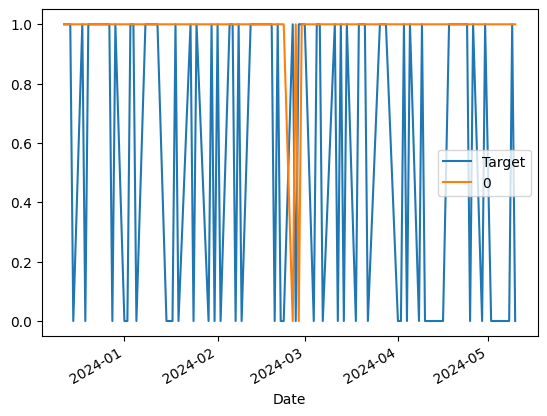

In [116]:
combined = pd.concat([test['Target'], preds], axis = 1)
combined.plot()

In [117]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name = "Predictions")
    combined = pd.concat([test['Target'], preds], axis = 1)
    return combined

def backtest(data, model, predictors, start = 2500, step = 250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [118]:
predictions = backtest(nse, model, predictors)

In [119]:
predictions["Predictions"].value_counts()

Predictions
1    826
0    753
Name: count, dtype: int64

In [120]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5411622276029056

In [121]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.548448
0    0.451552
Name: count, dtype: float64

In [122]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = nse.rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    nse[ratio_column] = nse["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    nse[trend_column] = nse.shift(1).rolling(horizon).sum()['Target']

    new_predictors += [ratio_column, trend_column]


nse = nse.dropna()

In [123]:
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

In [124]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name = "Predictions")
    combined = pd.concat([test['Target'], preds], axis = 1)
    return combined

In [125]:
predictions = backtest(nse, model, new_predictors)

In [126]:
predictions["Predictions"].value_counts()

Predictions
0.0    519
1.0     59
Name: count, dtype: int64

In [127]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5932203389830508

In [128]:
nse

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2011-10-13 00:00:00+05:30,5130.799805,5136.950195,5067.649902,5077.850098,0,5132.299805,1,0.997883,1.0,1.014789,3.0,0.992330,23.0,0.911365,111.0,1.042939,510.0
2011-10-14 00:00:00+05:30,5057.350098,5141.399902,5056.600098,5132.299805,0,5118.250000,0,1.005333,1.0,1.015754,3.0,1.004393,24.0,0.921801,111.0,1.053995,510.0
2011-10-17 00:00:00+05:30,5156.200195,5160.200195,5084.500000,5118.250000,0,5037.500000,0,0.998629,1.0,1.007444,2.0,1.003264,23.0,0.919921,111.0,1.051026,509.0
2011-10-18 00:00:00+05:30,5049.450195,5057.500000,5011.049805,5037.500000,0,5139.149902,1,0.992049,0.0,0.989091,2.0,0.989147,23.0,0.906187,110.0,1.034383,508.0
2011-10-19 00:00:00+05:30,5080.450195,5148.049805,5075.299805,5139.149902,0,5091.899902,0,1.009989,1.0,1.007477,2.0,1.010438,24.0,0.925163,111.0,1.055190,508.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-03 00:00:00+05:30,22766.349609,22794.699219,22348.050781,22475.849609,438100,22442.699219,0,0.996181,1.0,0.996338,2.0,1.012145,36.0,1.106079,152.0,1.347055,567.0
2024-05-06 00:00:00+05:30,22561.599609,22588.800781,22409.449219,22442.699219,320300,22302.500000,0,0.999262,0.0,0.994668,2.0,1.010206,35.0,1.103464,151.0,1.343984,567.0
2024-05-07 00:00:00+05:30,22489.750000,22499.050781,22232.050781,22302.500000,297800,22302.500000,0,0.996867,0.0,0.991450,1.0,1.003495,35.0,1.095658,150.0,1.334540,566.0


In [130]:
nse.loc[nse['Target'] == 1]

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2011-10-13 00:00:00+05:30,5130.799805,5136.950195,5067.649902,5077.850098,0,5132.299805,1,0.997883,1.0,1.014789,3.0,0.992330,23.0,0.911365,111.0,1.042939,510.0
2011-10-18 00:00:00+05:30,5049.450195,5057.500000,5011.049805,5037.500000,0,5139.149902,1,0.992049,0.0,0.989091,2.0,0.989147,23.0,0.906187,110.0,1.034383,508.0
2011-10-21 00:00:00+05:30,5106.600098,5120.750000,5037.950195,5049.950195,0,5098.350098,1,0.995864,0.0,0.992648,1.0,0.996729,22.0,0.910414,110.0,1.036818,506.0
2011-10-24 00:00:00+05:30,5114.700195,5145.649902,5084.750000,5098.350098,0,5191.600098,1,1.004769,1.0,1.002947,2.0,1.007862,23.0,0.919756,111.0,1.046721,506.0
2011-10-25 00:00:00+05:30,5137.899902,5211.000000,5085.549805,5191.600098,0,5360.700195,1,1.009062,2.0,1.015136,3.0,1.027498,24.0,0.937113,112.0,1.065824,506.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-23 00:00:00+05:30,22447.050781,22447.550781,22349.449219,22368.000000,231500,22402.400391,1,1.000707,2.0,1.007612,3.0,1.012637,35.0,1.108169,152.0,1.348224,566.0
2024-04-24 00:00:00+05:30,22421.550781,22476.449219,22384.000000,22402.400391,235900,22570.349609,1,1.000768,2.0,1.006853,4.0,1.013304,36.0,1.108831,153.0,1.349188,567.0
2024-04-26 00:00:00+05:30,22620.400391,22620.400391,22385.550781,22419.949219,329900,22643.400391,1,0.996657,1.0,1.000024,4.0,1.012431,36.0,1.107562,153.0,1.348062,567.0
